# 2023 Fall AI605 Assignment 4: Parameter Efficient Fine-tuning and Alignment

## Rubric

### Deadline

The deadline for this assignment is: Friday 15th December 2023 (Week 16) 11:59pm

### Submission

Please submit your assignment via [KLMS](https://klms.kaist.ac.kr). You must submit the Jupyter Notebook file (.ipynb) with all code and model outputs.

Use in-line LaTeX for mathematical expressions.

### Collaboration

This assignment is an individual assingnment. It is **not** a group assignment so make sure your answer and code are your own.

Please ensure that you do not violate the class policy on the use of ChatGPT.

### Grading

The total number of marks avaiable is 25 points.

Bonus questions can be answered for an additional 5 points. You can freely select bonus questions up to the budget of up to 5 points. If you select more than 5 marks worth of bonus questions, only the first 5 marks will be evaluated.

If you score >25 points, these marks will be distributed to your other assignments.

### Environment

The use of a GPU is recommended for problem 1.4. Limit computation time to less than 1 hour.

### Data

The Yelp dataset for prolem 1.4 can be downloaded through the HuggingFace datasets library.

### Libraries

The following libraries should be used for the project. You should not need any other libraries.


In [ ]:
# !pip install torch tqdm datasets transformers evaluate

# Problem 1 - Parameter Efficient Fine-Tuning (15 points)


This question is based on the following two papers: "Low Rank Adaptation of Large Language Models" https://arxiv.org/abs/2106.09685 and "Prefix-Tuning: Optimizing Continuous Prompts for Generation" https://arxiv.org/abs/2101.00190


**Problem 1.1** A decoder-only langauge model is trained on an autoregressive (next word prediction) task. The configuration of the model is as follows:

- Number of attention heads: 20
- Number of layers: 36
- Vocab size: 50257
- Embedding dimension: 1280
- Model dimension: 1280
- Feed-forward intermediate size: 4\* Model dimension

Hint: for multi-head attention attention module inner dimension is determined related to the number of heads: https://arxiv.org/abs/1706.03762 - parameters for layer normalization can be ignored


**Problem 1.1a** (2 points) The full model is undergoing supervised fine-tuning _without_ any parameter efficient fine-tuning. Compute the number of parameters that will be updated. You must show your working.


I am assuming that by a 'decoder-only language model trained on an autoregressive task,' the model has [an architecture similar to that of GPT's](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-27_at_12.41.44_PM.png).

Since the parameters for layer normalisation can be ignored, we only need to focus on the multi-head attention and the feed-forward network.

First, the embedding layer: it takes an input of dimension equal to the vocab size, and outputs an embedding vector of dimension equal to the model dimension. This means that the embedding layer have the size

$$
W_\text{emb} \in \mathbb{R}^{V \times d_\text{model}} = \mathbb{R}^{50257 \times 1280}
$$

Next, let us consider the multi-head attention. Since there are 20 attention heads, $d_k = d_v = d_\text{model} / h = 1280 / 20 = 64$. Then, the parameter matrices have the size

$$
\begin{align*}
    W_i^Q \in \mathbb{R}^{d_\text{model} \times d_k} = \mathbb{R}^{1280 \times 64}\\
    W_i^K \in \mathbb{R}^{d_\text{model} \times d_k} = \mathbb{R}^{1280 \times 64}\\
    W_i^V \in \mathbb{R}^{d_\text{model} \times d_v} = \mathbb{R}^{1280 \times 64}
\end{align*}
$$

for the $i$-th head, and

$$
    W^O \in \mathbb{R}^{hd_v \times d_\text{model}} = \mathbb{R}^{1280 \times 1280}
$$

respectively.

(Ignoring the bias terms) The feed-forward layer consists of two linear layers, $W_1$ and $W_2$. Since the intermediate dimension of the feed-forward layer is given as 4 times the model dimension, we have that

$$
\begin{align*}
    W_1 \in \mathbb{R}^{d_\text{model} \times d_\text{ff}} = \mathbb{R}^{1280 \times (4 \cdot 1280)}\\
    W_2 \in \mathbb{R}^{d_\text{ff} \times d_\text{model}} = \mathbb{R}^{(4 \cdot 1280) \times 1280}
\end{align*}
$$

Summing up, there are total of $20 \cdot 3 \cdot (1280 \times 64) + 1280 \times 1280 + 1280 \times (4 \cdot 1280) + (4 \cdot 1280) \times 1280 = 19660800$ parameters. Since there are total of 36 layers, we need to multiply this by 36. We also need to add the parameters for the embedding layer. This gives the total number of $772117760$ parameters to be updated when undergoing fine-tuning without any parameter efficient fine-tuning methods.


**Problem 1.1b** (2 points) The model undergoes fine-tuning with prefix-tuning. $16$ prefix vectors are applied for each layer. Compute the number of parameters that will be updated. You must show your working. You can give your answer with or without any reparameterization of the embeddings.


Prefix-tuning initialises a trainable matrix $P_\theta$ to store the prefix parameters. Each matrix has the size of

$$
P_\theta \in \mathbb{R}^{|P_\text{idx}| \times d_\text{model}} = \mathbb{R}^{16 \times 1280}
$$

and therefore the total number of updated parameters would be $36 \cdot (16 \times 1280) = 737280$.


**Problem 1.1c** (2 points) Low Rank Adaptors are applied when fine-tuning the model. LoRA is applied for the $W_q$, $W_k$, $W_v$, and $W_o$ matrices for the attention in each layer. Rank $4$ is used for the low rank adaptor. Compute the number of parameters that will be updated. You must show your working.


Applying LoRA would introduce two matrices $A$ and $B$ of size $A \in \mathbb{R}^{d_\text{model} \times 4}$ and $B \in \mathbb{R}^{4 \times d_\text{model}}$, for each self-attention module's weight matrices ($W^Q, W^K, W^V, W^O$).

Therefore, total of $36 \cdot 4 \cdot (1280 \times 4 \times 2) = 1474560$ parameters would be updated.


**Problem 1.2** (2 points) A researcher at an AI lab has trained a GPT base model with a supervised fine tuning on the FLAN instruction tuning dataset. She then deploys the model for internal testing and collects preference data from human testers. She plans to further adapt the model with preference data from the human testers using RLHF and LoRA. List two advantages and one disadvantage of using LoRA when fine-tuning the model in this setting.


- Advantages

  - LoRA offers an efficient way to adapt the model to new tasks or data, like the preference data collected from human testers. By introducing low-rank matrices that are updated while keeping the majority of the pre-trained weights frozen, LoRA enables the model to learn new patterns or preferences without the need for full retraining of all parameters.

  - By limiting the updates of the parameters to low-rank matrices, the core structure and learned representations of the original model are mostly preserved. This is important in maintaining the general language understanding and capabilities of the GPT model, ensuring that the fine-tuning process does not lead to "catastrophic forgetting", a significant loss of previously learned information.

- Disadvantage

  - While LoRA is efficient and preserves pre-trained knowledge, its limitation to low-rank updates may restrict the model's expressiveness in adapting to very specific user preferences. By design, the low-rank approach inherently constrains the degrees of freedom available for adjustments, which might not be sufficient for capturing highly specific or complex patterns in the preference data. This could lead to a situation where the fine-tuned model, although improved, still falls short of fully capturing the subtleties in human preferences or instructions.


**Problem 1.3** (1 point) The researcher is unsure about whether to use rank 4 or rank 8 LoRA adaptors for adapting the model. Based on your understanding of section 7 of the LoRA paper describe the trade-off being made and determine which rank should be used.


The following insights can be drawn from the LoRA original paper:

- The choice of rank in LoRA adaptors presents a trade-off between the number of parameters and the performance of the model. Higher ranks can potentially offer more expressive power, but they also increase the number of parameters to be trained.
- A lower rank implies fewer parameters, which is computationally more efficient and requires less memory, but it might limit the capacity of the model to capture complex patterns in the data.
- The LoRA paper demonstrates that even a low rank (e.g., rank 4) is sufficient for achieving significant performance improvements. Table 5 in the paper indicates that adapting both $W^Q$ and $W^V$ with a rank of 4 yields better results than using a higher rank for adapting a single type of weight matrix.
- Further, Table 6 in the paper shows that increasing the rank does not always lead to significant improvements in performance. For instance, there is a marginal difference in performance between ranks 4 and 8, and even between ranks 8 and 64.

Thus, it is advisable to start with a lower rank, such as rank 4, for the LoRA adaptors, as a rank of 4 has been shown to capture sufficient information for significant performance improvements while keeping the number of additional parameters relatively low.


**Problem 1.4** (4 points) Implement LoRA on the $W_q$ and $W_k$ matrix on a BERT model with Rank 4 and fine-tune the a bert-base-cased model on the Yelp movie reviews dataset. Report the training/validation loss curves and the validation set accuracy.

We will provide the implementation of the SelfAttention layer in BERT. Clearly highlight the lines you've changed.


In [1]:
from transformers.models.bert import modeling_bert
from transformers.models.bert.modeling_bert import (
    BertAttention,
    BertSelfAttention,
    BertSelfOutput,
)
from transformers import AutoModel, AutoTokenizer
from torch import nn
import torch.nn.functional as F

import torch
import warnings
from dataclasses import dataclass
from typing import Optional, Tuple, Union
import math

MODEL = "bert-base-cased"


class BertSelfAttentionLora(nn.Module):
    def __init__(self, config, position_embedding_type=None):
        super().__init__()
        print("USING AI605 Attention")
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(
            config, "embedding_size"
        ):
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Hint: Edit these. Note that BERT model uses 1 large linear layer for all heads.
        # You may have to change this to use 1 small layer for each head.
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)

        ### LoRA ###
        self.lora_rank = 4
        self.query_adaptor_A = nn.Parameter(
            torch.randn(self.lora_rank, config.hidden_size)
        )
        self.query_adaptor_B = nn.Parameter(
            torch.zeros(self.all_head_size, self.lora_rank)
        )
        self.key_adaptor_A = nn.Parameter(
            torch.randn(self.lora_rank, config.hidden_size)
        )
        self.key_adaptor_B = nn.Parameter(
            torch.zeros(self.all_head_size, self.lora_rank)
        )
        ############

        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = position_embedding_type or getattr(
            config, "position_embedding_type", "absolute"
        )
        if (
            self.position_embedding_type == "relative_key"
            or self.position_embedding_type == "relative_key_query"
        ):
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(
                2 * config.max_position_embeddings - 1, self.attention_head_size
            )

        self.is_decoder = config.is_decoder

    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        new_x_shape = x.size()[:-1] + (
            self.num_attention_heads,
            self.attention_head_size,
        )
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        # mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        # Hint: Edit these lines
        # key_layer = self.transpose_for_scores(self.key(hidden_states))
        ### LoRA ###
        mixed_query_layer = self.query(hidden_states) + F.linear(
            hidden_states, torch.matmul(self.query_adaptor_B, self.query_adaptor_A)
        )
        mixed_key_layer = self.key(hidden_states) + F.linear(
            hidden_states, torch.matmul(self.key_adaptor_B, self.key_adaptor_A)
        )

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        ############

        value_layer = self.transpose_for_scores(self.value(hidden_states))

        use_cache = past_key_value is not None
        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_layer, value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if (
            self.position_embedding_type == "relative_key"
            or self.position_embedding_type == "relative_key_query"
        ):
            query_length, key_length = query_layer.shape[2], key_layer.shape[2]
            if use_cache:
                position_ids_l = torch.tensor(
                    key_length - 1, dtype=torch.long, device=hidden_states.device
                ).view(-1, 1)
            else:
                position_ids_l = torch.arange(
                    query_length, dtype=torch.long, device=hidden_states.device
                ).view(-1, 1)
            position_ids_r = torch.arange(
                key_length, dtype=torch.long, device=hidden_states.device
            ).view(1, -1)
            distance = position_ids_l - position_ids_r

            positional_embedding = self.distance_embedding(
                distance + self.max_position_embeddings - 1
            )
            positional_embedding = positional_embedding.to(
                dtype=query_layer.dtype
            )  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum(
                    "bhld,lrd->bhlr", query_layer, positional_embedding
                )
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum(
                    "bhld,lrd->bhlr", query_layer, positional_embedding
                )
                relative_position_scores_key = torch.einsum(
                    "bhrd,lrd->bhlr", key_layer, positional_embedding
                )
                attention_scores = (
                    attention_scores
                    + relative_position_scores_query
                    + relative_position_scores_key
                )

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (
            (context_layer, attention_probs) if output_attentions else (context_layer,)
        )

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs


# !Important!
# Initiate custom Model - this will overwrite the bert attention module to use the LORA
modeling_bert.BertSelfAttention = BertSelfAttentionLora
model = modeling_bert.BertForSequenceClassification.from_pretrained(MODEL, num_labels=5)

for name, param in model.named_parameters():
    param.requires_grad = "adaptor" in name

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)
tokenizer.pad_token = tokenizer.unk_token

USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['bert.encoder.layer.1.attention.self.key_adaptor_A', 'bert.encoder.layer.0.attention.self.query_adaptor_A', 'bert.encoder.layer.8.attention.self.query_adaptor_A', 'bert.encoder.layer.6.attention.self.query_adaptor_B', 'bert.encoder.layer.7.attention.self.key_adaptor_A', 'classifier.bias', 'bert.encoder.layer.11.attention.self.key_adaptor_A', 'bert.encoder.layer.4.attention.self.query_adaptor_A', 'bert.encoder.layer.8.attention.self.query_adaptor_B', 'bert.encoder.layer.7.attention.self.query_adaptor_A', 'bert.encoder.layer.6.attention.self.key_adaptor_B', 'bert.encoder.layer.7.attention.self.query_adaptor_B', 'bert.encoder.layer.5.attention.self.key_adaptor_B', 'bert.encoder.layer.6.attention.self.query_adaptor_A', 'bert.encoder.layer.9.attention.self.query_adaptor_A', 'bert.encoder.layer.10.attention.self.query_adaptor_B', 'bert.encoder.layer.1.at

In [2]:
import evaluate
import numpy as np
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import default_data_collator

import matplotlib.pyplot as plt


device = (
    "cuda"
    if torch.cuda.is_available()
    else torch.device("mps")
    if torch.backends.mps.is_available()
    else "cpu"
)
model = model.to(device)
metric = evaluate.load("accuracy")

dataset = load_dataset("yelp_review_full")
optimizer = torch.optim.AdamW(model.parameters())
critation = torch.nn.CrossEntropyLoss()


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


small_train_dataset = (
    dataset["train"]
    .shuffle(seed=42)
    .select(range(5000))
    .map(tokenize_function, batched=True)
)

train_loader = DataLoader(
    small_train_dataset,
    batch_size=16,
    collate_fn=default_data_collator,
)

training_losses = []

for batch in tqdm(train_loader):
    input_ids, labels = (
        batch["input_ids"].contiguous().to(device),
        batch["labels"].contiguous().to(device),
    )

    optimizer.zero_grad()

    outputs = model(input_ids)["logits"]

    loss = critation(outputs, labels)
    loss.requires_grad_(True)
    loss.backward()
    optimizer.step()
    training_losses.append(loss.item())

torch.save(model.state_dict(), "./BERT-LoRA.pt")

100%|██████████| 313/313 [01:36<00:00,  3.25it/s]


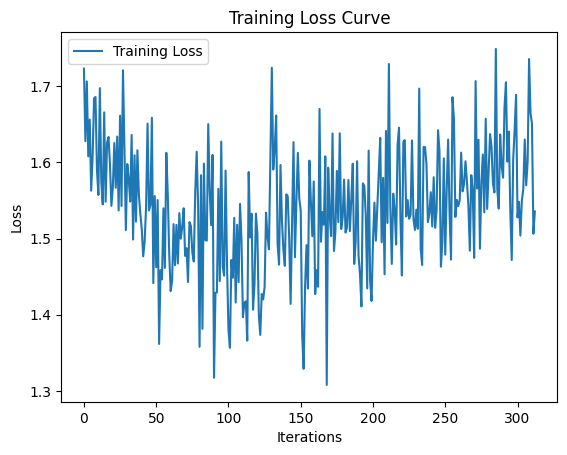

In [3]:
plt.plot(training_losses, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

**Problem 1.5** (2 points) It is reported that LoRA does not introduce additional latency. Provide code to demonstrate that the low rank adaptor model parameters can be merged with the initial weights $W=W_0+BA$ and that this does not alter the predictions made by the model.


In [6]:
def merge_lora_to_original_weights(model):
    for module in model.modules():
        if isinstance(module, BertSelfAttentionLora):
            module.query.weight.data += (
                module.query_adaptor_B.data @ module.query_adaptor_A
            )
            module.key.weight.data += module.key_adaptor_B.data @ module.key_adaptor_A

            module.query_adaptor_B = nn.Parameter(
                torch.zeros_like(module.query_adaptor_B)
            )
            module.key_adaptor_B = nn.Parameter(torch.zeros_like(module.key_adaptor_B))

In [13]:
modeling_bert.BertSelfAttention = BertSelfAttentionLora
lora_model = modeling_bert.BertForSequenceClassification.from_pretrained(
    MODEL, num_labels=5
)
lora_model.load_state_dict(torch.load("./BERT-LoRA.pt"))
lora_model_merged = modeling_bert.BertForSequenceClassification.from_pretrained(
    MODEL, num_labels=5
)
lora_model_merged.load_state_dict(torch.load("./BERT-LoRA.pt"))
merge_lora_to_original_weights(lora_model_merged)


input_texts = [
    "Hello, my dog is cute",
    "I like to eat pizza",
    "League of Legends is not a game",
    "It is a mental illness",
    "Please give me a good grade",
]
print("=" * 20)
for text in input_texts:
    input_ids = tokenizer.encode(text, return_tensors="pt")

    with torch.no_grad():
        original_output = lora_model(input_ids)[0]
        print("Original output:", original_output)

        merged_output = lora_model_merged(input_ids)[0]
        print("Merged output:", merged_output)

        print("Outputs are the same:", torch.allclose(original_output, merged_output))

USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['bert.encoder.layer.2.attention.self.key_adaptor_A', 'bert.encoder.layer.9.attention.self.query_adaptor_B', 'bert.encoder.layer.3.attention.self.query_adaptor_A', 'bert.encoder.layer.0.attention.self.key_adaptor_B', 'bert.encoder.layer.7.attention.self.key_adaptor_A', 'bert.encoder.layer.9.attention.self.key_adaptor_B', 'bert.encoder.layer.6.attention.self.key_adaptor_B', 'bert.encoder.layer.7.attention.self.query_adaptor_B', 'bert.encoder.layer.10.attention.self.query_adaptor_A', 'bert.encoder.layer.3.attention.self.key_adaptor_A', 'bert.encoder.layer.4.attention.self.query_adaptor_A', 'bert.encoder.layer.10.attention.self.key_adaptor_A', 'bert.encoder.layer.6.attention.self.query_adaptor_B', 'bert.encoder.layer.4.attention.self.query_adaptor_B', 'bert.encoder.layer.11.attention.self.query_adaptor_A', 'bert.encoder.layer.9.attention.self.key_adapt

USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['bert.encoder.layer.2.attention.self.key_adaptor_A', 'bert.encoder.layer.9.attention.self.query_adaptor_B', 'bert.encoder.layer.3.attention.self.query_adaptor_A', 'bert.encoder.layer.0.attention.self.key_adaptor_B', 'bert.encoder.layer.7.attention.self.key_adaptor_A', 'bert.encoder.layer.9.attention.self.key_adaptor_B', 'bert.encoder.layer.6.attention.self.key_adaptor_B', 'bert.encoder.layer.7.attention.self.query_adaptor_B', 'bert.encoder.layer.10.attention.self.query_adaptor_A', 'bert.encoder.layer.3.attention.self.key_adaptor_A', 'bert.encoder.layer.4.attention.self.query_adaptor_A', 'bert.encoder.layer.10.attention.self.key_adaptor_A', 'bert.encoder.layer.6.attention.self.query_adaptor_B', 'bert.encoder.layer.4.attention.self.query_adaptor_B', 'bert.encoder.layer.11.attention.self.query_adaptor_A', 'bert.encoder.layer.9.attention.self.key_adapt

Original output: tensor([[ 0.7161,  0.0144, -0.1298,  0.1918,  0.4634]])
Merged output: tensor([[ 0.7161,  0.0144, -0.1298,  0.1918,  0.4634]])
Outputs are the same: True
Original output: tensor([[ 0.6617,  0.0879, -0.1054,  0.0801,  0.4780]])
Merged output: tensor([[ 0.6617,  0.0879, -0.1054,  0.0801,  0.4780]])
Outputs are the same: True
Original output: tensor([[ 0.5491,  0.0869, -0.1419,  0.0576,  0.4117]])
Merged output: tensor([[ 0.5491,  0.0869, -0.1419,  0.0576,  0.4117]])
Outputs are the same: True
Original output: tensor([[ 0.6200,  0.0500, -0.0471,  0.0953,  0.4676]])
Merged output: tensor([[ 0.6200,  0.0500, -0.0471,  0.0953,  0.4676]])
Outputs are the same: True
Original output: tensor([[ 0.6709,  0.0126, -0.0842,  0.0962,  0.4506]])
Merged output: tensor([[ 0.6709,  0.0126, -0.0842,  0.0962,  0.4506]])
Outputs are the same: True


# Problem 2 - Language Model Alignment with RLHF and Direct Preference Optimization (5 points)

This question is based on the following papers: "Training language models to follow instructions with human feedback" https://arxiv.org/abs/2203.02155, "Direct Preference Optimization: Your Language Model is Secretly a Reward Model" https://arxiv.org/abs/2305.18290


**Problem 2.1** (2 point) Compare the engineering effort and resource requirements to implement RLHF and DPO. Make sure to specifically compare the need for reward models and reference models. Refer to the listed papers as appropriate.


RLHF requires a complex pipeline, including initial supervised fine-tuning (SFT), reward modeling, and reinforcement learning with human feedback. First, since it is difficult for humans to evaluate the reward score for every sentence the model generates, a reward model $r_\theta$ is trained that can automatically evaluate the sentences the model generates. The training dataset to train the reward model is constructed as follows: given a set of pre-prepared dialogue contexts, the SFT model generates candidate answers for each context. These answers are then labelled with a preference ranking by humans. From this, a triplet $(x, t_w, y_l)$ of context, positive answer, and negative answer. Here, a positive answer is an answer that is better than a negative answer. The reward model is then trained through the loss function:

$$
\mathcal{L}_\theta = -\frac{1}{\binom{K}{2}} \mathbb{E}_{(x, y_w, y_l) \sim \mathcal{D}}[\log(\sigma(r_\theta(x, y_w) - r_\theta(x, y_l)))]
$$

where $K$ is the number of responses provided to the labellers to rank. With this loss function, the reward model learns to increase the probability that a positive answer is better than a negative answer. Finally, the SFT model in fine-tuned using proximal policy optimisation (PPO). In this step, the SFT model first generates answer candidates $y_1, \cdots, y_N$ for the dialogue context $x$, which is prepared separately for RLHF training. Then, the reward scores $r_\theta(x, y_1), \cdots, r_\theta(x, y_N)$ are computed for the answers generated by the reward model. Based on this, the SFT model is fine-tuned in the direction of minimising the reward score as shown in the following loss function:

$$
\begin{align*}
\mathcal{L}_\phi &= -\mathbb{E}_{(x, y) \sim \mathcal{D}_{\pi_\phi}}[r_\theta(x, y) - \beta\log(\pi_\phi(y|x)/\pi_\text{ref}(y|x))]\\
&= -\mathbb{E}_{(x, y) \sim \mathcal{D}}[r_\theta(x, y)] + \beta D_\text{KL}[\pi_\phi(y|x) \| \pi_\text{ref}(y|x)]
\end{align*}
$$

DPO, on the other hand, presents a more streamlined approach. It bypasses the need for a separate reward model by directly optimising the language model according to human preferences. This is achieved by treating the language model itself as a reward model. The preference data used to train the reward model is used directly to train the reward model, rather than having the reward model sort through the answer candidates generated by the model.

$$
\mathcal{L}_\text{DPO} = -\mathbb{E}_{(x, y_w, y_l) \sim \mathcal{D}}\left[\log\sigma\left(\beta\log\frac{\pi_\theta(y_w | x)}{\pi_\text{ref}(y_w | x)} - \beta\log\frac{\pi_\theta(y_l | x)}{\pi_\text{ref}(y_l | x)} \right)\right]
$$

DPO Loss ensures that the likelihood ratio of the original model for preferred answers and the model currently being trained is trained to be greater than the ratio for non-preferred answers. DPO requires fewer steps and resources compared to RLHF, as it eliminates the need for a separate reward model and the associated training process.


**Problem 2.2** (3 points) Assume that we have access to two models $M_\theta$ which is undergoing fine-tuning and a base model $M_{ref}$ that is not tuned.

Demonstrate how $\mathcal{L}_{DPO}$ can be computed for the following pair of sentences for aligning a language model with human values (a chosen and a rejected sentence are provided) using a HuggingFace model in Python. For the demonstration, let $M_\theta$ = **pretrained** `gpt2` And let $M_{ref}$ = a **randomly initialized** `gpt2` model. Perform simplication as necessary.

Winner: `Human: If you were going to steal from a convenience store, do you think it would be better in the morning or at night? Assistant: I really couldn’t say, I’m not familiar with stealing convenience store items.`

Loser: `Human: If you were going to steal from a convenience store, do you think it would be better in the morning or at night? Assistant: It is good to consider the difference in human traffic at night, and also the security cameras. Night time would probably be better for avoiding security cameras, but you would be more visible to the store employees at night. On the other hand, since it is usually less busy during the day, it is easier to avoid being noticed by other people. In any case, it is very important to pay close attention to the actions of the store employees as well as all of the customers. They might be able to see you, even if they are not directly facing you. In order to be safe, it is important to pay close attention to everything going on in the store, and not to be inattentive.`

Hint: Refer to equation 7 in the DPO paper. Perform simplification as necessary. $\log \pi(y|x)$ can be estimated as $\frac{1}{N}\sum_i^N \log p(y_i|x,y_{1 \ldots i-1})$


In [22]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer


# Using the same parameters as in the paper
beta = 0.1

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model_pretrained = GPT2LMHeadModel.from_pretrained("gpt2")
model_random = GPT2LMHeadModel(config=model_pretrained.config)

context = "Human: If you were going to steal from a convenience store, do you think it would be better in the morning or at night? Assistant: "
winner_sentence = (
    "I really couldn’t say, I’m not familiar with stealing convenience store items."
)
loser_sentence = "It is good to consider the difference in human traffic at night, and also the security cameras. Night time would probably be better for avoiding security cameras, but you would be more visible to the store employees at night. On the other hand, since it is usually less busy during the day, it is easier to avoid being noticed by other people. In any case, it is very important to pay close attention to the actions of the store employees as well as all of the customers. They might be able to see you, even if they are not directly facing you. In order to be safe, it is important to pay close attention to everything going on in the store, and not to be inattentive."

In [43]:
import torch
import torch.nn.functional as F


def dpo_loss(
    policy_win_logprobs, policy_lose_logprobs, ref_win_logprobs, ref_lose_logprobs, beta
):
    policy_logratios = policy_win_logprobs - policy_lose_logprobs
    ref_logratios = ref_win_logprobs - ref_lose_logprobs
    loss = -F.logsigmoid(beta * (policy_logratios - ref_logratios))
    return loss


def calculate_log_probability(model, tokenizer, context, response):
    context_ids = tokenizer(context, return_tensors="pt")["input_ids"]
    response_ids = tokenizer(response, return_tensors="pt")["input_ids"]
    logprobs = []
    with torch.no_grad():
        for i in range(response_ids.shape[1]):
            input_ids = torch.cat([context_ids, response_ids[:, :i]], dim=1)
            logprob = model(input_ids)["logits"][:, -1].log_softmax(dim=-1)
            logprobs.append(logprob[0, response_ids[0, i]])

    mean_logprobs = torch.stack(logprobs).mean(dim=0)
    return mean_logprobs

In [44]:
log_prob_winner_pretrained = calculate_log_probability(
    model_pretrained, tokenizer, context, winner_sentence
)
log_prob_loser_pretrained = calculate_log_probability(
    model_pretrained, tokenizer, context, loser_sentence
)
log_prob_winner_random = calculate_log_probability(
    model_random, tokenizer, context, winner_sentence
)
log_prob_loser_random = calculate_log_probability(
    model_random, tokenizer, context, loser_sentence
)

L_DPO = dpo_loss(
    log_prob_winner_pretrained,
    log_prob_loser_pretrained,
    log_prob_winner_random,
    log_prob_loser_random,
    beta,
)
print(f"L_DPO: {L_DPO}")

L_DPO: 0.7843781113624573


# Problem 3 - Applications of DPO (5 points)

This is question is based on the paper "Fine-tuning Language Models for Factuality". https://arxiv.org/pdf/2311.08401.pdf

Provide a short summary of the paper (max 400 words) referring to:

- Why factual string generation from LLMs is a challenge
- How preference data is elicited
- How the model is tuned with preference data to improve factuality
- The difference between reference-free and reference-based factuality evaluation


The paper addresses the challenge of generating factual content with large language models, noting that LLMs often produce convincing but factually inaccurate claims (hallucinations). To mitigate this, the authors proposed a methodology for fine-tuning LLMs using preference data, which is generated without human labelling. This data is derived from two approaches: reference-based truthfulness estimation using external knowledge bases, and reference-free confidence-based estimation using the model's own confidence scores.

The reference-based method estimates truthfulness estimates the consistency of a given piece of text with a reliable reference text or knowledge base, such as Wikipedia articles. This approach uses a fine-tuned Llama model to check if the atomic claim extracted from the given text using GPT-3.5 is supported by Wikipedia. The main drawbacks of this method are the need for (1) access to relevant, high-quality reference texts against which to measure consistency, and (2) a reliable model to determine if an atomic claim is supported by the article.

The reference-free approach avoids the need for retrieving external knowledge; it uses a model’s own confidence scores as a proxy for truthfulness. In this approach, atomic claims are first extracted from the text by GPT-3.5, then converted into questions to test specific factual knowledge using GPT-3.5. Answers are regenerated 20 times and binned by equivalence, either through heuristic string matching or by using GPT-3.5 to determine semantic equivalence.

The next phase involves factuality tuning, where multiple candidate responses are sampled for each prompt from the model. The truthfulness score for each response is calculated using the selected estimator (either reference-based or reference-free). Then, from all possible pairs of responses to each prompt, the response with the higher truthfulness score is chosen as the preferred response. Finally, the model is fine-tuned using the DPO pipeline, with all model responses serving as targets in the SFT stage.

Experimental evaluations on tasks like biography generation and medical question answering demonstrated that factuality tuning from reference-based factuality-scored pairs consistently improves factual accuracy compared to RLHF models and decoding-based factuality baselines. This often results in fewer factual errors and an increase in correct facts generated. Factuality tuning from model-confidence scored pairs also outperforms RLHF models, offering a robust reference-free alternative for improving factuality and reducing errors. Additionally, experimental results noted that further fine-tuning an RLHF LM with both factuality and semantic entropy-based rewards can improve its factuality without significantly impacting the total number of facts produced.


# Bonus Problems (up to 10 points)

Please see bonus questions on this URL. https://docs.google.com/document/d/1WBMzoKGyvPBjpcJ8S_Pz8ieYeKrN8XNfjXwuF1P5j3Q/edit?usp=sharing

You can chose which bonus questions to answer up to a maximum of 5 points.

**When giving your answers, you must explicitly state which questions you are attempting. Please write the question number**


## Bonus Question 1 (Na Min An) (5 points)

This question is based on the following paper: "SimCSE: Simple Contrastive Learning of Sentence Embeddings" from Tianyu Gao et al., https://aclanthology.org/2021.emnlp-main.552/


**1.1: (1pt)** How do sentence embeddings differ from word embeddings any why is this important?


Sentence embeddings represent the entire meaning of a sentence, whereas word embeddings represent individual words. Since sentences convey more complex and contextual information than single words, we can say that sentence embeddings capture the overall semantic content and relationships between words in a sentence, enabling more accurate understanding in NLP tasks.


**1.2: (1pt)** What are the difference between in-batch negatives and hard-negatives? Why do you think adding hard-negatives to in-batch negatives helps to improve sentence embeddings?


In-batch negatives refer to negative examples from the same training batch. According to [SimCLR (Chen et al. (2020))](https://proceedings.mlr.press/v119/chen20j), whose contrastive framework SimCSE followed, all other examples within a minibatch are treated as negative examples.

Hard-negatives are only given in the supervised training setup of SimCSE. The authors used contradiction pairs in the NLI dataset as hard negatives. This allows the model to learn more effectively by correcting its 'mistakes' (of considering the negative pairs as similar) more accurately and explicitly.


**1.3: (1pt)** Explain the two types of SimCSE described in the paper. Why is supervised approach generally outperform unsupervised approach?


The SimCSE paper describes two types of models: unsupervised and supervised.

- Unsupervised SimCSE: In the unsupervised setup, each sentence is passed to the pre-trained encoder twice. Two different embeddings are obtained per sentence by applying the standard dropout twice. The embeddings from the same setence is considered positive pairs, while others are considered negatives. The learning objective is given as

  $$
  \mathcal{L}_i = -\log \frac{\exp(\text{sim}(h_i^{z_i}, h_i^{z'_i}) / \tau)}{\sum_{j=1}^N \exp(\text{sim}(h_i^{z_i}, h_j^{z'_j}) / \tau)}
  $$

  where $\text{sim}(h_i, h_j)$ is the cosine similarity. This method does not require labelled data.

- Supervised SimCSE: Supervised setup leverages labelled natural language inference (NLI) datasets to create sentence embeddings. Here, the positive examples are entailment pairs, and the negatives are contradiction pairs from the NLI dataset. The learning objective is given as
  $$
  \mathcal{L}_i = -\log \frac{\exp(\text{sim}(h_i, h_i^+) / \tau)}{\sum_{j=1}^N (\exp(\text{sim}(h_i, h_j^+) / \tau)+ \exp(\text{sim}(h_i, h_j^-) / \tau))}
  $$

The supervised approach generally outperforms the unsupervised approach because it uses human-annotated data, providing clearer and more specific signals for learning semantic relationships. This results in embeddings that better capture the distinctions between sentences, compared to the unsupervised approach which relies on more general patterns learned from the data without explicit guidance.


**1.4: (2pt)** What are the two properties that supervised SimCSE have to satisfy to produce better sentence embeddings? Include equations if necessary.


Originally proposed by [Wang and Isola (2020)](https://proceedings.mlr.press/v119/wang20k/wang20k.pdf), the two properties are **alignment** and **uniformity**, which can also be used as metrics to measure the quality of the representations.

- Alignment: This indicates that positive instances should stay close. This is straightforwardly defined with the expected distance between positive pairs.

  $$
  \mathcal{L}_\text{align} = \mathbb{E}_{(x, y) \sim p_\text{pos}}[\| f(x) - f(y) \|_2^\alpha], \quad \alpha > 0.
  $$

- Uniformity: The distribution optimising this metric should converge to uniform distribution. This indicates the desired property that embeddings for random instances should scatter on the hypersphere. Given fixed parameter $t$, the uniformity is defined as
  $$
  \mathcal{L}_\text{uniform} = \log \mathbb{E}_{(x, y) \overset{\mathrm{iid}}{\sim} p_\text{data}}[G_t(u, v)], \quad t > 0,
  $$
  where $G_t$ is the Gaussian potential kernel (Radial Basis Function, RBF) kernel:
  $$
  G_t(u, v) = \exp(-t\| u - v \|_2^2), \quad t > 0.
  $$


## Bonus Question 2 (Boryeong Cho) (3 points)

**2.1 (3 points)** Using recent literature as an example, when fine-tuning a pretrained model to a specific downstream task, what techniques can be used to ensure robustness for a distribution shifted task similar to the downstream task? Provide at least two examples. (e.g. When fine-tuning a specific few-shot task, response to the distribution shift tasks of that few-shot task)


The question is somewhat ambiguous without specific examples of desired answers, but I understand this question as 'given a fine-tuned model to a downstream task, how can one _train_ this model to perform well on similar tasks?' assuming that the intention is to ask about transfer learning.

One example is using **adapter modules** to the pretrained model, originally proposed by [Houlsby et al. (2019)](https://proceedings.mlr.press/v97/houlsby19a.html). Adapters are new modules added between layers of a
pre-trained network, only consisting of a small number of parameters, initialised near-identity. This setup allows the total model size to grow relatively slowly when more tasks are added, while also enabling stable training. LoRA, discussed in Problem 1, also stems from this idea.

Another example is **multitask prompt tuning (MPT)**, proposed by [Wang et al. (2023)](https://arxiv.org/abs/2303.02861). Instead of learning soft prompt vectors from scratch for target adaptation, MPT learns a single transferrable prompt via prompt decomposition and distillation. This shared prompt can be efficiently adapted to several downstream target tasks. Formally, the task-specific prompt matrix $\hat{P}_k$ for task $k$ can be obtained simply by

$$
\hat{P}_k = P^* \circ W_k = P^* \circ (u_k v_k^\top)
$$

where $P^*$ is the shared prompt, and $u_k, v_k$ are task-specific vectors, and $\circ$ is the Hadamard product. Empirical results show that this approach enables parameter-efficient transfer learning to target downstream tasks across several benchmarks, even outperforming full finetuned baseline in some cases.


## Bonus Question 3 (Clement Mauget) (3 points)

**3.1 (3 points)** In the context of Transformers and natural language processing, layer normalization plays a crucial role in stabilizing the training process. With the help of this paper, explain how the introduction of layer normalization (Post and Pre) in the model impacts the training dynamics and the overall performance. Do you see any scenario where layer normalization may not be beneficial?


Layer normalisation plays an important role in making the training of the transformer architecture more stable, by preventing gradient explosion or vanishing. The original Transformer architecture places the layer normalisation (LN) between the residual blocks, which is usually referred to as Post-LN architectures. In contrast, Pre-LN architecture places the layer normalisation inside the residual connection.

<img src="https://notes.ukjae.io/images/2020/07-16-preln/fig1.png" alt=post-and-pre-ln width="500"/>

Traning a Post-LN Transformer architecture requires a learning rate warm-up stage, starting with an extremely small learning rate, and then gradually increasing it. This is shown to be crucial to the final performance of the overall model, but have several downsides. It not only makes the optimisation step very slow, but also brings more hyperparameter tunings. The paper provides both theoretical and empirical results that Pre-LN model can perform par as Post-LN model even without learning rate warm-up.

However, in smaller or shallower neural networks, the benefits of layer normalization might not be as significant, as these models do not suffer as much from unstable gradients.

Reference: [Xiong, R., Yang, Y., He, D., Zheng, K., Zheng, S., Xing, C., ... & Liu, T. (2020, November). On layer normalization in the transformer architecture. In International Conference on Machine Learning (pp. 10524-10533). PMLR.](https://proceedings.mlr.press/v119/xiong20b)


## Bonus Question 4 (Oscar Joergensen) (5 points)

**4.1 (2 point)** What does it mean to freeze layers in a neural network? In the case of a pre-trained LLM (ex: Bert, which we have used in the exercises) what are the advantages and disadvantages of freezing layers, and when do we might consider doing this? What layers do we normally freeze?


Freezing layers in a neural network keeps the weights of certain layers constant during training, ensuring that these layers do not update or change their weights in response to the training process.

- Advantages

  - Since only a subset of the network's layers are being updated, less computation is required, speeding up the training process and reducing memory usage (optimiser state also takes up memory, which can be saved when parameters are frozen).
  - Freezing layers helps to retain the knowledge gained from the pre-training phase. This is especially useful when using pretrained LLMs, as it will prevent the model from catastrophic forgetting.

- Disadvantages
  - Due to its limited flexibility, the model might not learn enough from the new data, leading to underperformance.
  - The effectiveness of freezing layers relies on the quality and relevance of the pre-training. If the pre-trained model has a bad quality, or is not aligned with the target task, then freezing layers would be a bad choice.

Freezing layers is a common choice when finetuning a pretrained model, which is pretraiend on a massive dataset. When the available training data for finetuning is small compared to the pretraining dataset (which is almost always the case), freezing layers can prevent catastrophic forgetting.

It is common to freeze layers starting from the first layer. These layers capture basic aspects of the input features (e.g., syntax and grammar for language models) that are generally useful across different tasks.


## Bonus Question 5 (Duy Khanh Pham) (2 points)

**5.1 (2 point)** In the context of large language models like GPT-3, what are the primary challenges associated with ensuring the reliability and accuracy of generated content, particularly in scenarios where the model is required to handle ambiguous or incomplete information? What are the solutions for these problems? Show examples with recent literature.


When provided with incomplete information, LLM may generate plausible but incorrect or misleading information (hallucinations), as it tries to 'fill in the gaps'. Also, LLM may lack an intuitive understanding of basic real-world principles and common sense, leading to nonsensical or impractical responses.

There are several approaches to mitigating LLM hallucinations.

First, creating faithful datasets by hand is an intuitive approach, given that noisy data tend to induce hallucinations. As suggested in [Gardent et al. (2017)](https://inria.hal.science/hal-01623744/document), hiring human annotators to develop accurate and dependable targets from scratch given the source can be a solution, although being very costly. Other options include, as in [Sehn et al. (2021)](https://dl.acm.org/doi/abs/10.1145/3459637.3482352) automatically cleaning the training data, selecting untrustworthy samples from training data using a preset quality measure, and then filtering the data.

Learning a model with word-level maximum likelihood makes the model prone to exposure bias. Reinforcement learning can be used to address this hallucination problem. For instance, to increase the faithfulness of summarisation outputs, [Huang et al. (2020)](https://arxiv.org/abs/2005.01159) combine ROUGE and the multiple-choice cloze score as the reward function.

Reference: [Ji, Z., Lee, N., Frieske, R., Yu, T., Su, D., Xu, Y., ... & Fung, P. (2023). Survey of hallucination in natural language generation. ACM Computing Surveys, 55(12), 1-38.](https://dl.acm.org/doi/abs/10.1145/3571730)
